# Project: Mobile robot planning, control and estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import utils
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
from meshcat.transformations import translation_matrix, rotation_matrix
from meshcat.geometry import Box, MeshPhongMaterial, Cylinder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Visualization

In [2]:
# specify a path the the urdf files and meshes
urdf_model_path = "diffdrive.urdf"
mesh_dir = ""

# load the robot using pinocchio
robot = pin.RobotWrapper.BuildFromURDF(urdf_model_path, mesh_dir)

# vizualize the robot using meshcat
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# Add a floor
# Add floor material
material_floor = MeshPhongMaterial()
material_floor.color = int(200) * 256**2 + int(200) * 256 + int(200)
# Add a floor
viz.viewer["/Floor"].set_object(
    Box([10, 10, 0.01]),
    material_floor
)
viz.viewer["/Floor"].set_transform(
    translation_matrix([0, 0, -0.005])
)

# Add obstacle material
material_obstacle = MeshPhongMaterial()
material_obstacle.color = int(100) * 256**2 + int(100) * 256 + int(100)

# Randomly generate 10 obstacle positions within a defined range
np.random.seed(6) #6
obstacle_positions = [
    np.array([np.random.uniform(-4.8, 4.8), np.random.uniform(-4.8, 4.8), 0.5])
    for _ in range(10)
]

# add cylinders for each obstacle
for i, pos in enumerate(obstacle_positions):
    viz.viewer[f"/Obstacle_{i}"].set_object(
        Cylinder(1, 0.2), material_obstacle
    )
    T_world_obs = translation_matrix(pos)
    T_world_obs[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Obstacle_{i}"].set_transform(
        T_world_obs
    )
for i, pos in enumerate(obstacle_positions[::2]):
    # Connect a wall (box) between the two obstacles
    wall_length = np.linalg.norm(obstacle_positions[2*i][:2] - obstacle_positions[2*i+1][:2])
    wall_width = 0.4
    wall_height = 1.0
    wall_material = MeshPhongMaterial()
    wall_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

    wall_position = (obstacle_positions[2*i][:2] + obstacle_positions[2*i+1][:2]) / 2

    viz.viewer[f"/Wall_Obstacle_{i}"].set_object(
        Box([wall_length, wall_width, wall_height]), wall_material
    )
    # Set the wall rotation to align with the line between the two obstacles
    angle = np.arctan2(
        obstacle_positions[2*i+1][1] - obstacle_positions[2*i][1],
        obstacle_positions[2*i+1][0] - obstacle_positions[2*i][0]
    )
    viz.viewer[f"/Wall_Obstacle_{i}"].set_transform(
        translation_matrix([wall_position[0], wall_position[1], wall_height / 2]) @
        rotation_matrix(angle, [0, 0, 1])
    )

# Add walls around the floor
wall_thickness = 0.1
wall_height = 1.0

# Left wall
viz.viewer["/Wall_Left"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Left"].set_transform(
    translation_matrix([-5 - wall_thickness / 2, 0, wall_height / 2])
)

# Right wall
viz.viewer["/Wall_Right"].set_object(Box([wall_thickness, 10, wall_height]))
viz.viewer["/Wall_Right"].set_transform(
    translation_matrix([5 + wall_thickness / 2, 0, wall_height / 2])
)

# Front wall
viz.viewer["/Wall_Front"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Front"].set_transform(
    translation_matrix([0, 5 + wall_thickness / 2, wall_height / 2])
)

# Back wall
viz.viewer["/Wall_Back"].set_object(Box([10, wall_thickness, wall_height]))
viz.viewer["/Wall_Back"].set_transform(
    translation_matrix([0, -5 - wall_thickness / 2, wall_height / 2])
)

# can you add a tower in each corner of the walls?
tower_height = 1.5
tower_radius = 0.3
tower_material = MeshPhongMaterial()
tower_material.color = int(100) * 256**2 + int(100) * 256 + int(100)

tower_positions = [
    np.array([-5 - wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, 5 + wall_thickness / 2, tower_height / 2]),
    np.array([-5 - wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2]),
    np.array([5 + wall_thickness / 2, -5 - wall_thickness / 2, tower_height / 2])
]

for i, pos in enumerate(tower_positions):
    viz.viewer[f"/Tower_{i}"].set_object(
        Cylinder(tower_height, tower_radius), tower_material
    )
    T_world_tower = translation_matrix(pos)
    T_world_tower[:3, :3] = pin.utils.rotate('x', np.pi / 2)
    viz.viewer[f"/Tower_{i}"].set_transform(
        T_world_tower
    )

In [4]:
x,y,theta = 0,0,0
utils.show_robot(x, y, theta, viz)

## Object collision

### Definition of collision models

In [5]:
import collisions as co

# Load collision model and data of the robot
model = robot.model
data = robot.data
geom_model = robot.collision_model
geom_data = pin.GeometryData(geom_model)

robot_radius = utils.compute_robot_radius(geom_model)
print(f"Robot radius: {robot_radius:.3f} meters")

Robot radius: 0.296 meters


In [6]:
# Initialize the collision objects for all obstacles
# and the collision pairs with all robot parts

params = utils.dotdict({
    "obstacle_positions": obstacle_positions,
    "obstacle_height": 1,
    "obstacle_radius": 0.2,
    "tower_height": 1.5,
    "tower_radius": 0.3,
    "wall_thickness": 0.1,
    "wall_width": 10,
    "wall_height": 1.0,
    "conn_wall_width": 0.4,
    "conn_wall_height": 1.0,
})

geom_model, geom_data = co.init_obstacles(robot, geom_model, params)

## PRM

### PRM algorithm

In [7]:
import prm

# Hyperparameters
N = 1000
k = 10
xlim = [-5,5]
ylim = [-5,5]
bias_prob = 0.5
std = 0.3

model_config = [model, data, geom_model, geom_data]

In [8]:
# Takes up to 15 min (with N=1000, k=10)

samples = prm.get_samples(N, xlim, ylim, geom_model, bias_prob, std)
R = prm.PRM_Graph(samples)

for p1 in range(len(R.nodes)):
    neighbors = R.knn(p1, k)
    for p2 in neighbors:
        if R.exists_edge(p1, p2):
            continue
        timesteps = R.local_path(p1, p2)
        R.add_edge(p1, p2, co.is_collision_free(timesteps, *model_config))

# Visualize on MeshCat
R.show_graph(viz)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



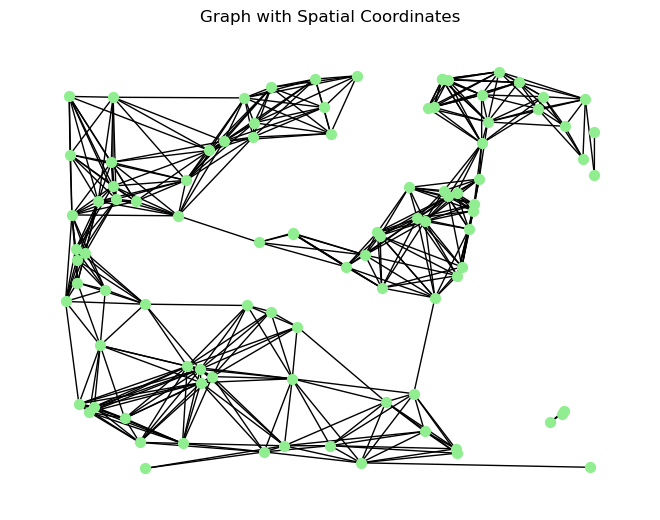

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualize on a 2d plot as a network
nodes = {i:v for i, v in enumerate(R.nodes)}

G = nx.Graph()
G.add_edges_from(R.edges)

# Use actual positions for layout
nx.draw(G, pos=nodes, node_color='lightgreen', node_size=50)
plt.title("Graph with Spatial Coordinates")
plt.show()

#### Compare collision checkers time complexity

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compare pinnochio collision checker with approximate version
def benchmark(N, xlim, ylim, geom_model, geom_data, k, bias_prob, std, robot_radius, obstacle_radius, model, data):
    samples = prm.get_samples(N, xlim, ylim, geom_model, bias_prob, std)
    R = prm.PRM_Graph(samples)
    model_config = [geom_model, robot_radius, obstacle_radius]

    # Approximate checker
    start_approx = time.perf_counter()
    for p1 in range(len(R.nodes)):
        neighbors = R.knn(p1, k)
        for p2 in neighbors:
            if R.exists_edge(p1, p2): continue
            timesteps = R.local_path(p1, p2)
            R.add_edge(p1, p2, co.is_collision_free_approx(timesteps, *model_config))
    duration_approx = time.perf_counter() - start_approx

    samples = prm.get_samples(N, xlim, ylim, geom_model, bias_prob, std)
    R = prm.PRM_Graph(samples)
    model_config = [model, data, geom_model, geom_data]
    # Pinocchio checker
    start_pin = time.perf_counter()
    for p1 in range(len(R.nodes)):
        neighbors = R.knn(p1, k)
        for p2 in neighbors:
            if R.exists_edge(p1, p2): continue
            timesteps = R.local_path(p1, p2)
            R.add_edge(p1, p2, co.is_collision_free(timesteps, *model_config))
    duration_pin = time.perf_counter() - start_pin

    print(f"Approximate checker took {duration_approx:.3f} s")
    print(f"Pinocchio checker took   {duration_pin:.3f} s")
    return duration_approx, duration_pin

def scalability_test(N_values, k_values, xlim, ylim, geom_model, geom_data,
                     bias_prob, std, robot_radius, obstacle_radius, model, data):
    results = []
    for N in N_values:
        for k in k_values:
            dur_approx, dur_pin = benchmark(
                N, xlim, ylim, geom_model, geom_data,
                k, bias_prob, std,
                robot_radius, obstacle_radius,
                model, data
            )
            results.append({'N': N, 'k': k, 'method': 'approx', 'duration': dur_approx})
            results.append({'N': N, 'k': k, 'method': 'pinocchio', 'duration': dur_pin})

    df = pd.DataFrame(results)

    # Plot: duration vs N, hue=method, col per k
    g = sns.relplot(
        data=df,
        x='N', y='duration', hue='method',
        col='k', kind='line', marker='o'
    )
    g.set_axis_labels('Number of Samples N', 'Duration (s)')
    g.set_titles('k = {col_name}')
    plt.tight_layout()
    # plt.savefig('scaling_checker.jpg')
    plt.show()

In [45]:
N_values = [50, 200, 1000]
k_values = [5, 10]
scalability_test(
    N_values, k_values,
    xlim=[-5,5], ylim=[-5,5],
    geom_model=geom_model, geom_data=geom_data,
    bias_prob=0.5, std=0.3,
    robot_radius=robot_radius, obstacle_radius=obstacle_radius,
    model=model, data=data
)

Approximate checker took 26.154 s
Pinocchio checker took   27.183 s
Approximate checker took 49.029 s
Pinocchio checker took   52.486 s
Approximate checker took 103.536 s
Pinocchio checker took   108.704 s
Approximate checker took 196.152 s
Pinocchio checker took   200.170 s
Approximate checker took 555.630 s
Pinocchio checker took   520.811 s
Approximate checker took 1006.424 s
Pinocchio checker took   1072.639 s


NameError: name 'pd' is not defined

## Simulation

In [2]:
# Define robot dynamics
def discrete_dynamics(state, control_input, dt, model_mismatch=False):
    """
    Update the robot's state based on its dynamics.

    Parameters:
    - state: Current state [x, y, theta]
    - control_input: Control input [linear_velocity, angular_velocity]
    - dt: Time step

    Returns:
    - Updated state [x, y, theta]
    """
    x, y, theta = state
    linear_velocity, angular_velocity = control_input
    if model_mismatch:
        # Introduce model mismatch by adding noise to the control input
        linear_velocity += np.random.normal(0, 1.0)
        angular_velocity += np.random.normal(0, 1.0)

    # Update state using differential drive kinematics
    x += linear_velocity * np.cos(theta) * dt
    y += linear_velocity * np.sin(theta) * dt
    theta += angular_velocity * dt

    # Normalize theta to keep it within [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    return np.array([x, y, theta])


In [9]:
def simulation(controller):
    # Simulation parameters
    radius = 1.0  # Radius of the circle
    linear_velocity = 1.5  # Linear velocity (m/s)
    angular_velocity = -linear_velocity / radius  # Angular velocity (rad/s)
    dt = 0.01  # Time step (s)
    simulation_time = 5  # Total simulation time (s)
    sensor_noise_stddev = 0.03  # Standard deviation of sensor noise (m)

    # Initial robot position and orientation
    x, y, theta = 0.0, 0.0, 0.0  # Initial position (x, y) and orientation (theta)

    # Simulation loop
    for t in np.arange(0, simulation_time, dt):

        z = np.array([x,y]) + np.random.normal(0, sensor_noise_stddev, 2)  # Simulated sensor measurement with noise

        # calculate control inputs
        u,w = controller(x,y,theta,z)

        # Update robot position and orientation using differential drive kinematics
        x, y, theta = discrete_dynamics([x, y, theta], [u,w], dt, model_mismatch=True)

        # Normalize theta to keep it within [-pi, pi]
        theta = np.arctan2(np.sin(theta), np.cos(theta))

        # Display the robot in the visualization
        utils.show_robot(x, y, theta, viz)
        # Calculate and visualize distances to towers

        # Pause to simulate real-time visualization
        time.sleep(dt)

In [10]:
def controller(x,y,theta,z):
    return 2, -2

In [11]:
simulation(controller)